# Final Project: Build a predictive model for determining if a customer transaction is fraudulent



Our customer is an e-commerce site that sells wholesale electronics. You have been contracted to build

a model that predicts whether a given transaction is fraudulent or not. You only have information

about each user’s first transaction on the company's website. If you fail to identify a fraudulent

transaction, the company loses money equivalent to the price of the fraudulently purchased product. If

you incorrectly flag a real transaction as fraudulent, it inconveniences the customers

whose valid transactions are flagged—a cost your client values at $8.

So, the task is to build a model that's predictive but also minimizes to cost to the company not only by correctly flagging and identifying fraudulent transactions but also to minimize the cost of wrong predictions since each wrong prediction costs the company $8.

You can use any model that we learned about in the class or you might have learnt about else where. The evaluation criteria will be total cost to company for the test data provided; for example if your model identifies 100 cases as fraudulent while they are normal transactions, this would cost the company $8 * 100  = $800.

There are 2 files included in this assignment:

- training data to build your models:

datasetForFinalAssignment.csv
- test data to apply your models to predict if the transaction id fraudulent or not.

datasetForFinalTest.csv

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# 1.0 Clear ipython memory
%reset -f

# Common imports
import numpy as np
import pandas as pd
import os
import gc
import time
import datetime as dt

# to make this notebook's output stable across runs
#Somehow this is not happening as o/p of models is not consistent
np.random.seed(42)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [4]:
# 1.1 Working with imbalanced data
# http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.SMOTE.html
# Check imblearn version number as:
#   import imblearn;  imblearn.__version__
from imblearn.over_sampling import SMOTE, ADASYN


In [5]:
# 1.2 Class for applying multiple data transformation jobs
from sklearn.compose import ColumnTransformer as ct
# Scale numeric data
from sklearn.preprocessing import StandardScaler as ss
# One hot encode data--Convert to dummy
from sklearn.preprocessing import OneHotEncoder as ohe


In [6]:
# 1.3 Dimensionality reduction
from sklearn.decomposition import PCA

# 1.4 Data splitting and model parameter search
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


# 1.5 Modeling modules
# conda install -c anaconda py-xgboost
#from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout


# 1.6 Model evaluation metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve

# 1.7
import matplotlib.pyplot as plt

Using TensorFlow backend.



##### *Step1*  -- Load the Dataset into a dataframe called transactions and Preparing the graphs for the labeled data
#####       -- Load the Validation Dataset into a dataframe called validate


In [7]:
transactions = pd.read_csv("datasetForFinalAssignment (1).csv")
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74691 entries, 0 to 74690
Data columns (total 14 columns):
Column 1                     74691 non-null int64
user_id                      74691 non-null int64
signup_time                  74691 non-null object
purchase_time                74691 non-null object
signup_time-purchase_time    74691 non-null int64
purchase_value               74691 non-null int64
device_id                    74691 non-null object
source                       74691 non-null object
browser                      74691 non-null object
sex                          74691 non-null object
age                          74691 non-null int64
ip_address                   74691 non-null float64
class                        74691 non-null int64
N[device_id]                 74691 non-null int64
dtypes: float64(1), int64(7), object(6)
memory usage: 8.0+ MB


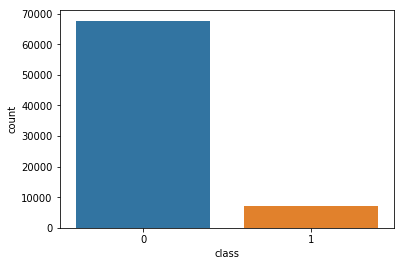

In [8]:
import seaborn as sns
sns.countplot(x="class", data=transactions)

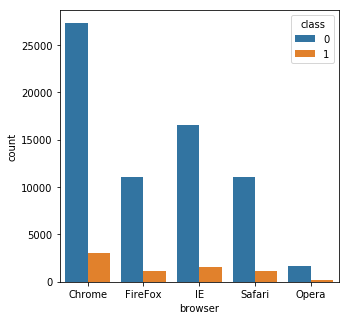

In [9]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
sns.countplot("browser",hue="class", data=transactions, ax=ax)
plt.show()

In [10]:
## In first graph, we found that the data is highly imbalanced and any predictions will lead to non-fraudlent decisions.
## From the second graph, we got to know that Chrome is having the most imbalanced data. 

In [11]:
validate=pd.read_csv("datasetForFinalTest.csv")
validate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13413 entries, 0 to 13412
Data columns (total 13 columns):
Column 1                     13413 non-null int64
user_id                      13413 non-null int64
signup_time                  13413 non-null object
purchase_time                13413 non-null object
signup_time-purchase_time    13413 non-null int64
purchase_value               13413 non-null int64
device_id                    13413 non-null object
source                       13413 non-null object
browser                      13413 non-null object
sex                          13413 non-null object
age                          13413 non-null int64
ip_address                   13413 non-null float64
N[device_id]                 13413 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 1.3+ MB


In [12]:
#columns = transactions.columns
#columns
transactions.head()

,Column 1,user_id,signup_time,purchase_time,signup_time-purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,N[device_id]
0,149671,285108,07/15/2015 4:36 AM,09/10/2015 2:17 PM,82661,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,2
1,84546,229053,01/07/2015 1:19 PM,01/09/2015 10:12 AM,2693,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,1
2,35978,108439,02/08/2015 9:11 PM,04/09/2015 2:26 PM,85995,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,1
3,103053,178528,04/20/2015 8:19 PM,08/03/2015 8:17 PM,151198,35,HUFZWLDYJPRCK,SEO,Chrome,F,30,2.550204e+09,0,1
4,101025,70424,07/05/2015 4:54 PM,08/25/2015 4:08 PM,73394,43,YDLNPVEWMTMMZ,Direct,IE,M,40,3.310808e+09,0,1


signup_time-purchase_time: provides the information of timeElapsed between signup and purchase. This is already provided so no need to compute timeBetween

N[device_id]: also provided so no need to compute numberOfTimesDeviceUsed

### Insight from data exploration:

   - Time between signup and purchase and how many times the same device was used are important, we'll explore the relationship between target variable and the new features that we created *timeBetween* and *numberOfTimesDeviceUsed* in detail
   - Looks like the categorical values are sampled similarly for both values of target variable, no concern for sampling bias 

##### What percentage of all the transactions in our dataset were fraudulent transactions?

Percentage of all the transactions in our dataset that were fraudulent = 9.38 %

##### Step5 -- Making copies of test and validation data


In [13]:
X = transactions.copy() # independent variables data
y = X['class']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74691 entries, 0 to 74690
Data columns (total 14 columns):
Column 1                     74691 non-null int64
user_id                      74691 non-null int64
signup_time                  74691 non-null object
purchase_time                74691 non-null object
signup_time-purchase_time    74691 non-null int64
purchase_value               74691 non-null int64
device_id                    74691 non-null object
source                       74691 non-null object
browser                      74691 non-null object
sex                          74691 non-null object
age                          74691 non-null int64
ip_address                   74691 non-null float64
class                        74691 non-null int64
N[device_id]                 74691 non-null int64
dtypes: float64(1), int64(7), object(6)
memory usage: 8.0+ MB


In [14]:
X.drop(columns = ['class'], inplace = True)
X.drop(columns = ['Column 1','user_id','device_id','ip_address','signup_time','purchase_time'], inplace = True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74691 entries, 0 to 74690
Data columns (total 7 columns):
signup_time-purchase_time    74691 non-null int64
purchase_value               74691 non-null int64
source                       74691 non-null object
browser                      74691 non-null object
sex                          74691 non-null object
age                          74691 non-null int64
N[device_id]                 74691 non-null int64
dtypes: int64(4), object(3)
memory usage: 4.0+ MB


In [15]:
X_val = validate.copy()

In [16]:
X_val.drop(columns = ['Column 1','user_id','device_id','ip_address','signup_time','purchase_time'], inplace = True)
X_val.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13413 entries, 0 to 13412
Data columns (total 7 columns):
signup_time-purchase_time    13413 non-null int64
purchase_value               13413 non-null int64
source                       13413 non-null object
browser                      13413 non-null object
sex                          13413 non-null object
age                          13413 non-null int64
N[device_id]                 13413 non-null int64
dtypes: int64(4), object(3)
memory usage: 733.6+ KB


In [17]:
X.head()

,signup_time-purchase_time,purchase_value,source,browser,sex,age,N[device_id]
0,82661,31,Direct,Chrome,M,49,2
1,2693,29,SEO,Chrome,M,34,1
2,85995,26,Ads,FireFox,M,33,1
3,151198,35,SEO,Chrome,F,30,1
4,73394,43,Direct,IE,M,40,1


##### Step6 -- Dealing with Categorical and Numerical Variables
##### calling OneHotEncoder and StandardScaler within the ColumnTransformer


In [18]:
#Define the transformation function using columnTransformer, OHE and StandardScaler
def transform(categorical_columns,numerical_columns,df):
    #  Create a tuple of processing tasks:
    #  (taskName, objectToPerformTask, columns-upon-which-to-perform)
    # 9.1 One hot encode categorical columns
    cat = ('categorical', ohe() , categorical_columns  )
    # 9.2 Scale numerical columns
    num = ('numeric', ss(), numerical_columns)
    # 9.3 Instantiate columnTransformer object to perform task
    #     It transforms X separately by each transformer
    #     and then concatenates results.
    col_trans = ct([cat, num])
    # 9.4 Learn data
    col_trans.fit(df)
    # 9.5 Now transform df
    df_transAndScaled = col_trans.transform(df)
    # 9.6 Return transformed data and also transformation object
    return df_transAndScaled, col_trans


In [19]:
#Define the columns for transformations
categorical_columns = ['source', 'browser','sex']
numerical_columns = ['signup_time-purchase_time', 'purchase_value','age','N[device_id]']

In [20]:
X.source.unique() # ['Direct', 'SEO', 'Ads'] 3 values --> columns 0,1,2

array(['Direct', 'SEO', 'Ads'], dtype=object)

In [21]:
X.browser.unique() # ['Chrome', 'FireFox', 'IE', 'Safari', 'Opera'] 5 values  --> columns 3,4,5,6,7

array(['Chrome', 'FireFox', 'IE', 'Safari', 'Opera'], dtype=object)

In [22]:
X.sex.unique() # ['M', 'F'] 2 values --> columns 8,9

array(['M', 'F'], dtype=object)

In [23]:
#Define the columns for post transformation dataframe - makes referencing and understanding easier
columns = ['source_Direct','source_SEO','source_Ads','browser_Chrome','browser_FireFox','browser_IE','browser_Safari','browser_Opera','sex_M','sex_F'] + numerical_columns
columns

['source_Direct',
 'source_SEO',
 'source_Ads',
 'browser_Chrome',
 'browser_FireFox',
 'browser_IE',
 'browser_Safari',
 'browser_Opera',
 'sex_M',
 'sex_F',
 'signup_time-purchase_time',
 'purchase_value',
 'age',
 'N[device_id]']

In [24]:
# 10.0 Transform X dataset
X_transAndScaled, _  = transform(categorical_columns, numerical_columns, X)

# 10.1
X_transAndScaled.shape # (74691, 14)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


(74691, 14)

##### Restoring the index and columns names
##### Restoring index helps in correctly compute the cost using unscaled purchase_value

In [25]:
X_transAndScaled = pd.DataFrame(X_transAndScaled, index=X.index, columns=columns)
X_transAndScaled.head()

,source_Direct,source_SEO,source_Ads,browser_Chrome,browser_FireFox,browser_IE,browser_Safari,browser_Opera,sex_M,sex_F,signup_time-purchase_time,purchase_value,age,N[device_id]
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.009090,-0.320634,1.835765,0.223419
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.525820,-0.429593,0.099640,-0.257486
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.073083,-0.593031,-0.016102,-0.257486
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.324593,-0.102717,-0.363327,-0.257486
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.168781,0.333118,0.794090,-0.257486


In [26]:
# 11.0 Transform X_val dataset
Xval_transAndScaled, _  = transform(categorical_columns, numerical_columns, X_val)

# 10.1
Xval_transAndScaled.shape           # (13413, 14)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


(13413, 14)

In [27]:
#Provide the column names for additional dummy variables
Xval_transAndScaled = pd.DataFrame(Xval_transAndScaled, index=X_val.index, columns=columns)
Xval_transAndScaled.head()

,source_Direct,source_SEO,source_Ads,browser_Chrome,browser_FireFox,browser_IE,browser_Safari,browser_Opera,sex_M,sex_F,signup_time-purchase_time,purchase_value,age,N[device_id]
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.883410,-1.143551,-0.835293,-0.258280
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.873579,0.176463,-0.015378,-0.258280
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.369936,2.321485,-0.718163,0.214921
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.169777,0.176463,-1.538078,-0.258280
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.285259,0.341464,0.804537,-0.258280


In [28]:
# 12. Split data into train/test
#     train-test split. save the indices of split set
X_train,X_test, y_train, y_test ,indicies_tr,indicies_test = train_test_split(
                                                                      X_transAndScaled,    # Predictors
                                                                      y,                # Target
                                                                      np.arange(X_transAndScaled.shape[0]),
                                                                      test_size = 0.3,   # split-ratio
                                                                      random_state=1
                                                                     )

In [29]:
X_train.shape

(52283, 14)

In [30]:
#Generate the image of test dataset pre-split using indicies_test.
#This will be used to capture the unscaled values of purchase_value for computing cost of model
X_cost = X.iloc[indicies_test]
X_cost.purchase_value.head()

85       59
4978     32
68017    44
42773    17
73790    46
Name: purchase_value, dtype: int64

In [31]:
#Using Garbage Collect to clear memory
del X_transAndScaled
del indicies_tr
del indicies_test
gc.collect()

150

In [32]:
type(y_train)
#y_train.info()

pandas.core.series.Series

#### Data Processing with SMOTE

In [33]:
#12.0 Checking the extent of 'class' imbalance
np.sum(y_train)/len(y_train)       # 0.09431363923263776

0.09299389859036399

In [34]:
# 12.1  Process X_train data with SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)
type(X_res)       # No longer pandas dataframe
                  #  but we will convert to pandas dataframe



numpy.ndarray

In [35]:
# 12.2 Check
X_res.shape                    # (94756, 14)

(94842, 14)

In [36]:
#Using y_res for most of the classifiers
#Using y_onehot for NeuralNetworks
y_onehot = pd.get_dummies(y_res)
y_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94842 entries, 0 to 94841
Data columns (total 2 columns):
0    94842 non-null uint8
1    94842 non-null uint8
dtypes: uint8(2)
memory usage: 185.3 KB


In [37]:
np.sum(y_res)/len(y_res)       # 0.5 ,earlier ratio was 0.09381634565728822

0.5

In [38]:
#y_res = y_res.reshape(len(y_res),1)
y_res = pd.DataFrame(y_res)
type(y_res)

pandas.core.frame.DataFrame

In [39]:
X_res = pd.DataFrame(X_res,columns=columns)
type(X_res)

pandas.core.frame.DataFrame

### Ready for Modeling
##### X_res, y_res (or y_onehot)
### For testing model accuracy
##### X_test, y_test
### For model validation
##### Xval_transAndScaled 
##### y_prediction.to_csv("submissionFirstNameLastName.csv")
### For model selection need the costing function:
##### calculate the cost of wrong response: $8*wrongFraudulent + purchase value of allFraudsMissed

In [40]:
def modelCost(test_y,model_y,df):
    #falsePositive: Cost is $8*count
    #non-fraudulent transactions (test_y '0') predicted as fraudulent by model (model_y '1')
    falsePositiveCost = df.purchase_value[(test_y==0) & (model_y==1)].count()*8
    print("falsePositive {:.0f}".format(df.purchase_value[(test_y==0) & (model_y==1)].count()))
    print("falsePositiveCost ${:.0f}".format(falsePositiveCost))
    #falseNegative: Cost is sum of purchase_value
    #fraudulent transactions (test_y '1') predicted as non-fraudulent by model (model_y '0')
    falseNegativeCost = df.purchase_value[(test_y==1) & (model_y==0)].sum()
    print("falseNegative {:.0f}".format(df.purchase_value[(test_y==1) & (model_y==0)].count()))
    print("falseNegativeCost ${:.0f}".format(falseNegativeCost))
    totalCost = falsePositiveCost + falseNegativeCost
    print("totalCost ${:.0f}".format(totalCost))
    return totalCost


# Check-0: All y's predicted as 0 (i.e. non-fraudulent transactions)

In [41]:
y0s=np.zeros(y_test.size)
totalCost_0s = modelCost(y_test, y0s, X_cost)

falsePositive 0
falsePositiveCost $0
falseNegative 2145
falseNegativeCost $79288
totalCost $79288


##### Customer loses $76393 from fraudulent transactions incorrectly classified as non-fraudulent

# Check-1: All y's predicted as 1 (i.e. fraudulent transactions)

In [42]:
y1s=np.ones(y_test.size)
totalCost_1s = modelCost(y_test, y1s, X_cost)

falsePositive 20263
falsePositiveCost $162104
falseNegative 0
falseNegativeCost $0
totalCost $162104


##### Customer loses \$162104 as now all non-fraudulent transactions are incorrectly classified as fraudulent
##### So our models should predict costs that are better than \$79288 for the model to be of some value

# Model-1: LogisticRegression

In [43]:
#Running basic regression first to setup all checking and evaluation functions
log_reg = LogisticRegression(random_state=42)
start = time.time()
log_reg.fit(X_res, y_res)
end = time.time()
(end - start) #0.31 seconds

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5911209583282471

In [44]:
y_logreg = log_reg.predict(X_test)
log_reg.score(X_test, y_test) #0.920653338093538 Not bad for a start!

0.9186004998214923

In [45]:
totalCost_logreg = modelCost(y_test, y_logreg, X_cost)
totalCost_logreg # $35238

falsePositive 1125
falsePositiveCost $9000
falseNegative 699
falseNegativeCost $25957
totalCost $34957


34957

# Model-2: LogisticRegression With L1 Penalty

In [46]:
########## Logistic Regression With L1 Penalty ##########
# logistic regression with L1 penalty
start = time.time()
logreg_l1 = LogisticRegression(C=0.1, penalty='l1')
logreg_l1.fit(X_res, y_res)
end = time.time()
print("LOGISTIC REGRESSION - L1 penalty took {:.2f}s".format(end - start)) #0.57s

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LOGISTIC REGRESSION - L1 penalty took 1.82s


In [47]:
logreg_l1.coef_
y_logregl1 = logreg_l1.predict(X_test)
logreg_l1.score(X_test, y_test) #0.9206087111745805 not much improvement

0.9183773652267048

In [48]:
totalCost_logregl1 = modelCost(y_test, y_logregl1, X_cost)
totalCost_logregl1 # $35262 -- Cost degrades!

falsePositive 1131
falsePositiveCost $9048
falseNegative 698
falseNegativeCost $25946
totalCost $34994


34994

# Model-3: LogisticRegression With L2 Penalty

In [49]:
########## Logistic Regression With L2 Penalty ##########
# logistic regression with L2 penalty
start = time.time()
logreg_l2 = LogisticRegression(C=0.1, penalty='l2')
logreg_l2.fit(X_res, y_res)
end = time.time()
print("LOGISTIC REGRESSION - L2 penalty took {:.2f}s".format(end - start)) #0.46s

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LOGISTIC REGRESSION - L2 penalty took 0.55s


In [50]:
logreg_l2.coef_
y_logregl2 = logreg_l2.predict(X_test)
logreg_l2.score(X_test, y_test) #0.920653338093538 not much improvement

0.9186004998214923

In [51]:
totalCost_logregl2 = modelCost(y_test, y_logregl2, X_cost)
totalCost_logregl2 # $35291 -- Cost degrades significantly!

falsePositive 1124
falsePositiveCost $8992
falseNegative 700
falseNegativeCost $26007
totalCost $34999


34999

# Model-4: DecisionTreeClassifier

In [52]:
########## DecisionTreeClassifier ##########
#from sklearn.tree import DecisionTreeClassifier
start = time.time()
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X_res, y_res)
end = time.time()
print("DecisionTreeClassifier took {:.2f}s".format(end - start)) #0.27s

DecisionTreeClassifier took 0.25s


In [53]:
y_treeclf = treeclf.predict(X_test)
treeclf.score(X_test, y_test) #0.9201178150660478

0.9181096037129597

In [54]:
totalCost_treeclf = modelCost(y_test, y_treeclf, X_cost)
totalCost_treeclf # $34890 -- Cost improves slightly from $35238 for logisticRegression!

falsePositive 1140
falsePositiveCost $9120
falseNegative 695
falseNegativeCost $25831
totalCost $34951


34951

# Model-5: RandomForestClassifier

In [55]:
########## RandomForestClassifier ##########
#from sklearn.ensemble import RandomForestClassifier
start = time.time()
#rfclf = RandomForestClassifier(n_estimators=200, max_features=5, oob_score=True, random_state=1)
rfclf = RandomForestClassifier(n_estimators=200, max_features=5, random_state=1)
rfclf.fit(X_res, y_res)
end = time.time()
print("DecisionTreeClassifier took {:.2f}s".format(end - start)) #44.71s

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


DecisionTreeClassifier took 52.98s


In [56]:
y_rfclf = rfclf.predict(X_test)
rfclf.score(X_test, y_test) #0.9364512674044984

0.9358711174580507

In [57]:
totalCost_rfclf = modelCost(y_test, y_rfclf, X_cost)
totalCost_rfclf # $38259 -- Cost degrades majorly from $34890 for DecisionTreeClassifier!

falsePositive 497
falsePositiveCost $3976
falseNegative 940
falseNegativeCost $35374
totalCost $39350


39350

# Model-6: 2-layer NeuralNetwork

In [58]:
X_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94842 entries, 0 to 94841
Data columns (total 14 columns):
source_Direct                94842 non-null float64
source_SEO                   94842 non-null float64
source_Ads                   94842 non-null float64
browser_Chrome               94842 non-null float64
browser_FireFox              94842 non-null float64
browser_IE                   94842 non-null float64
browser_Safari               94842 non-null float64
browser_Opera                94842 non-null float64
sex_M                        94842 non-null float64
sex_F                        94842 non-null float64
signup_time-purchase_time    94842 non-null float64
purchase_value               94842 non-null float64
age                          94842 non-null float64
N[device_id]                 94842 non-null float64
dtypes: float64(14)
memory usage: 10.1 MB


In [59]:
y_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94842 entries, 0 to 94841
Data columns (total 2 columns):
0    94842 non-null uint8
1    94842 non-null uint8
dtypes: uint8(2)
memory usage: 185.3 KB


In [60]:
start = time.time()
NN_2l = Sequential()
NN_2l.add(Dense(input_dim=14, output_dim=100))
NN_2l.add(Dense(output_dim=2))
NN_2l.add(Activation("softmax"))

NN_2l.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

NN_2l.fit(X_res, y_onehot)

end = time.time()
print("2layer NeuralNetwork took {:.2f}s".format(end - start)) #6.9s


Instructions for updating:
Colocations handled automatically by placer.


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=14, units=100)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=2)`
  after removing the cwd from sys.path.


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
94842/94842 [==============================] - 6s 63us/step - loss: 0.4486 - acc: 0.7788
2layer NeuralNetwork took 6.66s


In [61]:
y_NN2l = NN_2l.predict_classes(X_test)
print("\n\naccuracy", np.sum(y_NN2l == y_test) / float(len(y_test)))



accuracy 0.9197161727954302


In [62]:
totalCost_NN2l = modelCost(y_test, y_NN2l, X_cost)
totalCost_NN2l # $33575 -- Cost improvement from $34890 for DecisionTreeClassifier!

falsePositive 1087
falsePositiveCost $8696
falseNegative 712
falseNegativeCost $26584
totalCost $35280


35280

# Conclusion: 

In [63]:
## Decision Tree Classifier is the best model with 91.8% accuracy and $25831 of least false negetive cost.
## Other models were also close enough to Decision tree classifier. 
## purchase_value though impacting the cost has lesser role to play in classifying a transaction is fraudulent OR not.
## Given the high cost associated with falseNegative, I would recommend to adopt treeclf algorithm.

In [64]:
Xval_transAndScaled.head()

,source_Direct,source_SEO,source_Ads,browser_Chrome,browser_FireFox,browser_IE,browser_Safari,browser_Opera,sex_M,sex_F,signup_time-purchase_time,purchase_value,age,N[device_id]
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.883410,-1.143551,-0.835293,-0.258280
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.873579,0.176463,-0.015378,-0.258280
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.369936,2.321485,-0.718163,0.214921
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.169777,0.176463,-1.538078,-0.258280
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.285259,0.341464,0.804537,-0.258280
